# Práctica 2 — Solución Analítica (YouTube Comment Sentiment)

**Dataset:** `AmaanP314/youtube-comment-sentiment` (Hugging Face)

**Objetivo:**  
1) Definir una variable objetivo discreta y una continua (y justificar).  
2) Entrenar el mejor modelo para la discreta.  
3) Entrenar el mejor modelo para la continua.  
4) Interpretación en función del negocio.

In [ ]:
import pandas as pd
import numpy as np

from datasets import load_dataset

from textblob import TextBlob

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier,
    LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    classification_report,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    ConfusionMatrixDisplay,
    confusion_matrix,
    cohen_kappa_score
)

import matplotlib.pyplot as plt

## 0. Carga y exploración inicial del dataset

En esta sección:
- Cargamos el dataset desde Hugging Face.
- Revisamos columnas disponibles.
- Verificamos tamaño y valores faltantes.

In [14]:
try:
    df = load_dataset("AmaanP314/youtube-comment-sentiment")["train"].to_pandas()
except Exception:
    df = pd.read_parquet("../data/train.parquet")

df.shape, df.columns

((1032225, 12),
 Index(['CommentID', 'VideoID', 'VideoTitle', 'AuthorName', 'AuthorChannelID',
        'CommentText', 'Sentiment', 'Likes', 'Replies', 'PublishedAt',
        'CountryCode', 'CategoryID'],
       dtype='object'))

### Auditoría inicial del dataset (calidad y consistencia)

Objetivos:
1) Revisar **missing** (NaN/None) en TODAS las columnas.
2) Detectar **missing disfrazados**: strings vacíos, espacios, "nan", "null", etc.
3) Validar tipos (dtypes) y rangos básicos (Likes/Replies).
4) Parsear `PublishedAt` y medir fallos de parseo.
5) Ver cardinalidad de categóricas (`Sentiment`/`CountryCode`/`CategoryID`).

In [15]:
missing_all = df.isna().mean().sort_values(ascending=False)
missing_all[missing_all > 0]

AuthorName    0.000611
dtype: float64

In [16]:
def disguised_missing_stats(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    stripped = s.str.strip()

    missing_words = {"", "nan", "null", "none", "na", "n/a", "nil", "missing"}

    is_empty = stripped.eq("")
    is_word_missing = stripped.str.lower().isin(missing_words)

    is_literal_na = stripped.eq("<NA>")

    return pd.Series({
        "pct_empty_or_spaces": float(is_empty.mean()),
        "pct_missing_words": float(is_word_missing.mean()),
        "pct_literal_<NA>": float(is_literal_na.mean()),
        "examples_empty": stripped[is_empty].head(3).tolist(),
        "examples_missing_words": stripped[is_word_missing].head(3).tolist(),
    })

text_cols = ["VideoTitle", "AuthorName", "AuthorChannelID", "CommentText", "CountryCode", "PublishedAt", "Sentiment"]
audit_text = pd.DataFrame({c: disguised_missing_stats(df[c]) for c in text_cols}).T
audit_text


,pct_empty_or_spaces,pct_missing_words,pct_literal_<NA>,examples_empty,examples_missing_words
VideoTitle,0.0,0.0,0.0,[],[]
AuthorName,0.0,0.0,0.0,[],[]
AuthorChannelID,0.0,0.0,0.0,[],[]
CommentText,0.000156,0.00016,0.0,"[, , ]","[, , ]"
CountryCode,0.0,0.0,0.0,[],[]
PublishedAt,0.0,0.0,0.0,[],[]
Sentiment,0.0,0.0,0.0,[],[]


In [17]:
df["Sentiment"].value_counts(dropna=False)

Sentiment
Negative    346075
Positive    343317
Neutral     342833
Name: count, dtype: int64

In [18]:
cc = df["CountryCode"].astype("string").str.strip()
cc_len = cc.str.len()

{
    "pct_missing_like_empty": float((cc_len==0).mean()),
    "len_counts_top": cc_len.value_counts(dropna=False).head(10).to_dict(),
    "sample_weird_len": cc[~cc_len.isin([0,2])].dropna().unique()[:15].tolist()
}

{'pct_missing_like_empty': 0.0,
 'len_counts_top': {np.int64(2): 1032225},
 'sample_weird_len': []}

In [19]:
cat = pd.to_numeric(df["CategoryID"], errors="coerce")
{
    "pct_non_numeric": float(cat.isna().mean()),
    "min": float(cat.min()),
    "max": float(cat.max()),
    "n_unique": int(cat.nunique(dropna=True)),
    "top_values": cat.value_counts().head(10).to_dict()
}

{'pct_non_numeric': 0.0,
 'min': 1.0,
 'max': 28.0,
 'n_unique': 11,
 'top_values': {25: 332543,
  27: 290237,
  26: 85502,
  17: 69322,
  15: 49635,
  24: 48406,
  28: 47887,
  2: 44749,
  20: 32088,
  22: 17532}}

In [20]:
likes = pd.to_numeric(df["Likes"], errors="coerce")
replies = pd.to_numeric(df["Replies"], errors="coerce")

{
    "likes_pct_non_numeric": float(likes.isna().mean()),
    "replies_pct_non_numeric": float(replies.isna().mean()),
    "likes_pct_negative": float((likes < 0).mean()),
    "replies_pct_negative": float((replies < 0).mean()),
    "likes_desc": likes.describe(percentiles=[.5,.9,.95,.99]).to_dict(),
    "replies_desc": replies.describe(percentiles=[.5,.9,.95,.99]).to_dict(),
}

{'likes_pct_non_numeric': 0.0,
 'replies_pct_non_numeric': 0.0,
 'likes_pct_negative': 0.0,
 'replies_pct_negative': 0.0,
 'likes_desc': {'count': 1032225.0,
  'mean': 101.66075419603284,
  'std': 1538.978145542954,
  'min': 0.0,
  '50%': 0.0,
  '90%': 35.0,
  '95%': 157.0,
  '99%': 1633.0,
  'max': 275849.0},
 'replies_desc': {'count': 1032225.0,
  'mean': 2.023081208069946,
  'std': 14.144702381178911,
  'min': 0.0,
  '50%': 0.0,
  '90%': 2.0,
  '95%': 7.0,
  '99%': 42.0,
  'max': 751.0}}

In [21]:
published_dt = pd.to_datetime(df["PublishedAt"], errors="coerce", utc=True)

{
    "pct_parse_fail": float(published_dt.isna().mean()),
    "min_dt": str(published_dt.min()),
    "max_dt": str(published_dt.max()),
    "sample_raw_failures": df.loc[published_dt.isna(), "PublishedAt"].astype("string").head(10).tolist()
}

{'pct_parse_fail': 0.0,
 'min_dt': '2013-04-05 22:47:16+00:00',
 'max_dt': '2025-02-05 14:33:11+00:00',
 'sample_raw_failures': []}

In [22]:
dup_commentid = df["CommentID"].duplicated().mean()
dup_text = df["CommentText"].astype("string").str.strip().duplicated().mean()

{"pct_dup_commentid": float(dup_commentid), "pct_dup_commenttext": float(dup_text)}

{'pct_dup_commentid': 0.00035457385744387123,
 'pct_dup_commenttext': 0.04103368936036232}

### Limpieza final para modelado

Aplicamos limpieza mínima y justificada:

1) Eliminamos comentarios con `CommentText` vacío (espacios).
2) Eliminamos duplicados por `CommentID` (consistencia de identificador).
3) Parseamos `PublishedAt` a datetime y creamos variables de tiempo.
4) (Opcional) Eliminamos duplicados exactos de `CommentText` para reducir leakage.

In [23]:
df_model = df.copy()

# 1) Quitar textos vacíos o solo espacios
df_model["CommentText"] = df_model["CommentText"].astype("string")
mask_nonempty = df_model["CommentText"].str.strip().fillna("").ne("")
df_model = df_model[mask_nonempty].copy()

# 2) Deduplicar por CommentID (mantener primera ocurrencia)
df_model = df_model.drop_duplicates(subset=["CommentID"], keep="first").copy()

# 3) Parseo de fecha + features temporales
df_model["published_dt"] = pd.to_datetime(df_model["PublishedAt"], errors="coerce", utc=True)
df_model["hour"] = df_model["published_dt"].dt.hour
df_model["dow"] = df_model["published_dt"].dt.dayofweek
df_model["month"] = df_model["published_dt"].dt.month
df_model["is_weekend"] = df_model["dow"].isin([5,6]).astype(int)

# Targets
df_model["y_disc"] = df_model["Sentiment"].astype(str)
df_model["Likes"] = pd.to_numeric(df_model["Likes"], errors="coerce")
df_model["Replies"] = pd.to_numeric(df_model["Replies"], errors="coerce")

df_model["y_cont"] = np.log1p(df_model["Likes"].astype(float))

df_model.shape, df_model[["CommentText","y_disc","Likes","Replies","hour","dow","month","is_weekend","y_cont"]].head(10)

((1031698, 19),
                                          CommentText    y_disc  Likes  \
 0                    Anyone know what movie this is?   Neutral      0   
 1  The fact they're holding each other back while...  Positive      0   
 2                        waiting next video will be?   Neutral      1   
 3  Thanks for the great video.\n\nI don't underst...   Neutral      0   
 4  Good person helping good people.\nThis is how ...  Positive      3   
 5                                   Dei løk de seim😂   Neutral      0   
 6       Number two because it looks the best with it  Positive      0   
 7  Thank God we don’t have to listen to his drive...  Positive      0   
 8  Very similar thing happened to me! We lived ne...  Positive      0   
 9                                   im about to cry😢  Negative      0   
 
    Replies  hour  dow  month  is_weekend    y_cont  
 0        2     0    2      1           0  0.000000  
 1        0    23    0      1           0  0.000000  
 2    

#### Exploración de etiquetado automático de sentimiento (TextBlob)

Como parte del análisis preliminar del problema, se exploró una alternativa de etiquetado automático del sentimiento basada en la polaridad de **TextBlob**, generando una etiqueta exploratoria (`y_disc_custom`) con las tres clases tradicionales: Negative, Neutral y Positive.

El objetivo de esta exploración fue evaluar el nivel de acuerdo entre un enfoque automático de etiquetado y la etiqueta original provista por el dataset, antes de definir formalmente la variable objetivo discreta a utilizar en el proceso de modelado.

Para ello, se comparó `y_disc_custom` contra la etiqueta original (`Sentiment`) en una muestra aleatoria de **500,000** observaciones, permitiendo identificar discrepancias estructurales entre ambas definiciones de sentimiento.

In [32]:
def label_sentiment_textblob(text: str, pos_thr=0.10, neg_thr=-0.10):
    t = "" if text is None else str(text).strip()
    if t == "":
        return "Neutral"
    p = TextBlob(t).sentiment.polarity
    if p >= pos_thr:
        return "Positive"
    if p <= neg_thr:
        return "Negative"
    return "Neutral"

df_model["y_disc_custom"] = df_model["CommentText"].apply(label_sentiment_textblob)

df_model["y_disc_custom"].value_counts(normalize=True)

y_disc_custom
Neutral     0.495631
Positive    0.377619
Negative    0.126749
Name: proportion, dtype: float64

Tamaño muestra: 500000
Accuracy (acuerdo): 0.4882
Cohen's Kappa: 0.2331

Reporte (custom vs real):
              precision    recall  f1-score   support

    Negative     0.6216    0.2349    0.3409    167673
     Neutral     0.4248    0.6349    0.5090    165727
    Positive     0.5265    0.5972    0.5596    166600

    accuracy                         0.4882    500000
   macro avg     0.5243    0.4890    0.4699    500000
weighted avg     0.5247    0.4882    0.4695    500000



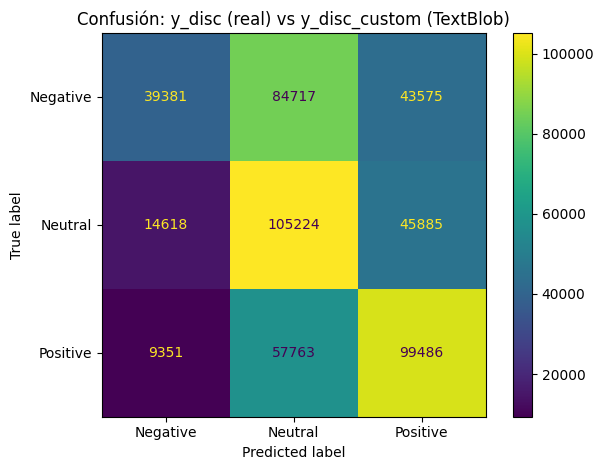

In [ ]:
df_cmp = df_model.dropna(subset=["y_disc","y_disc_custom"]).sample(500_000, random_state=777).copy()

y_true = df_cmp["y_disc"].astype(str)
y_pred = df_cmp["y_disc_custom"].astype(str)

labels = ["Negative", "Neutral", "Positive"]

acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred, labels=labels)

print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
print("Cohen's Kappa:", round(cohen_kappa_score(y_true, y_pred, labels=labels), 4))
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, labels=labels, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(values_format="d")
plt.title("Matriz de confusión: y_disc (real) vs y_disc_custom (TextBlob)")
plt.tight_layout()
plt.show()

**Decisión de etiquetado:**  
El etiquetado automático basado en TextBlob presentó acuerdo limitado con la etiqueta original (n=500,000; Accuracy=0.4882; Kappa=0.2331), con discrepancias relevantes en Negative (recall≈0.2349).  
Por lo anterior, se mantuvo `y_disc` como etiqueta oficial del modelo y `y_disc_custom` solo como referencia exploratoria.

In [31]:
df_model.describe().T

,count,mean,std,min,25%,50%,75%,max
Likes,1031698.0,101.637467,1539.344425,0.0,0.0,0.0,2.000000,275849.000000
Replies,1031698.0,2.020498,14.139358,0.0,0.0,0.0,0.000000,751.000000
CategoryID,1031698.0,23.181596,6.272917,1.0,24.0,25.0,27.000000,28.000000
hour,1031698.0,11.405214,6.880521,0.0,5.0,12.0,17.000000,23.000000
dow,1031698.0,2.812742,2.056540,0.0,1.0,2.0,5.000000,6.000000
month,1031698.0,3.449760,3.482981,1.0,1.0,2.0,5.000000,12.000000
is_weekend,1031698.0,0.274158,0.446089,0.0,0.0,0.0,1.000000,1.000000
y_cont,1031698.0,0.949587,1.743920,0.0,0.0,0.0,1.098612,12.527613


## 1. Variables objetivo

Se requieren dos variables objetivo:

### 1.1 Variable objetivo discreta (clasificación)
Definimos la variable objetivo discreta como:

- **y_disc = Sentiment** ∈ {Negative, Neutral, Positive}

**Justificación / utilidad (negocio):**
Clasificar el sentimiento de comentarios permite monitorear reputación, moderación de contenido, priorización de atención y análisis del clima de la comunidad.

### 1.2 Variable objetivo continua (regresión)
Definimos la variable objetivo continua como el engagement del comentario medido por likes:

- **Likes** = número de "me gusta" del comentario  
- Debido a que `Likes` suele ser altamente asimétrico (muchos ceros y pocos valores grandes), se usa:
- **y_cont = log1p(Likes)** = log(1 + Likes)

**Justificación / utilidad (negocio):**
Predecir engagement permite priorizar comentarios valiosos, mejorar ranking/visibilidad y asignar recursos de moderación o respuesta.

In [13]:
df_model[["y_disc", "Likes", "y_cont"]].head(5)

,y_disc,Likes,y_cont
0,Neutral,0,0.000000
1,Positive,0,0.000000
2,Neutral,1,0.693147
3,Neutral,0,0.000000
4,Positive,3,1.386294


In [14]:
df_model["y_disc"].value_counts(normalize=True).round(4)

y_disc
Negative    0.3354
Positive    0.3326
Neutral     0.3321
Name: proportion, dtype: float64

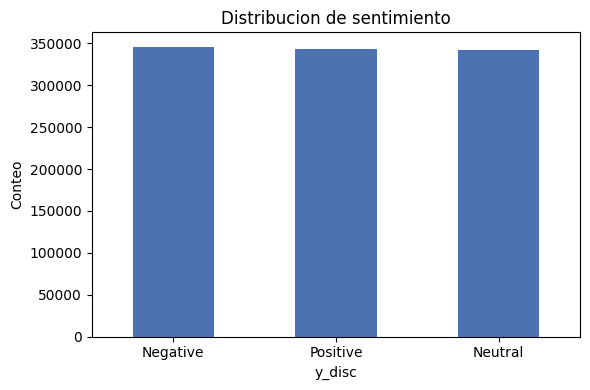

In [15]:
plt.figure(figsize=(6, 4))
df_model["y_disc"].value_counts().plot(kind="bar", color="#4C72B0")
plt.title("Distribucion de sentimiento")
plt.ylabel("Conteo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

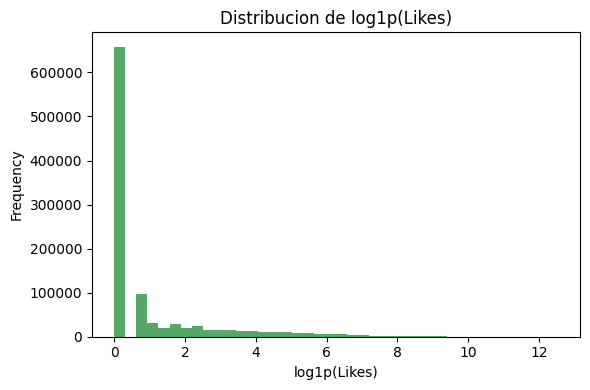

In [16]:
plt.figure(figsize=(6, 4))
np.log1p(df_model["Likes"]).plot(kind="hist", bins=40, color="#55A868")
plt.title("Distribucion de log1p(Likes)")
plt.xlabel("log1p(Likes)")
plt.tight_layout()
plt.show()

## 2. Selección del mejor modelo (clasificación)

Se comparan varios modelos lineales sobre una misma representación TF-IDF:

- LogisticRegression (baseline)
- SGDClassifier (varias pérdidas / regularizaciones)

Criterios de evaluación:
- **F1-macro** (principal, multiclass)
- **ROC-AUC One-vs-Rest (OVR)** (si hay `predict_proba` o `decision_function`)
- Matriz de confusión y reporte por clase

Se elige como “mejor” el modelo con mejor desempeño promedio en validación cruzada.

In [17]:
df_work = df_model.sample(200_000, random_state=777)

X = df_work["CommentText"].astype(str)
y = df_work["y_disc"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=777, stratify=y
)

X_train.shape, X_test.shape

((140000,), (60000,))

In [18]:
def evaluate_classifier(pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    out = {
        "accuracy": accuracy_score(y_test, pred),
        "f1_macro": f1_score(y_test, pred, average="macro"),
    }

    # ROC-AUC OVR (si es posible)
    try:
        if hasattr(pipe, "predict_proba"):
            scores = pipe.predict_proba(X_test)
            out["roc_auc_ovr"] = roc_auc_score(y_test, scores, multi_class="ovr")
        elif hasattr(pipe, "decision_function"):
            scores = pipe.decision_function(X_test)
            out["roc_auc_ovr"] = roc_auc_score(y_test, scores, multi_class="ovr")
        else:
            out["roc_auc_ovr"] = np.nan
    except Exception:
        out["roc_auc_ovr"] = np.nan

    return out

In [19]:
pipe_sgd = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ("model", SGDClassifier(random_state=777))
])

param_dist = {
    "model__loss": ["log_loss", "modified_huber", "hinge"],
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__alpha": np.logspace(-6, -3, 30),
    "model__l1_ratio": np.linspace(0, 1, 11),
}

search_sgd = RandomizedSearchCV(
    pipe_sgd,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=777,
    verbose=1
)

search_sgd.fit(X_train, y_train)
best_cls = search_sgd.best_estimator_
search_sgd.best_params_, search_sgd.best_score_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


({'model__penalty': 'l2',
  'model__loss': 'modified_huber',
  'model__l1_ratio': np.float64(0.0),
  'model__alpha': np.float64(9.236708571873866e-05)},
 np.float64(0.6737149719846749))

In [20]:
pred = best_cls.predict(X_test)

print("F1 macro (test):", f1_score(y_test, pred, average="macro"))
# ROC-AUC OVR (si aplica)
try:
    if hasattr(best_cls, "predict_proba"):
        scores = best_cls.predict_proba(X_test)
    else:
        scores = best_cls.decision_function(X_test)
    print("ROC-AUC OVR (test):", roc_auc_score(y_test, scores, multi_class="ovr"))
except Exception as e:
    print("ROC-AUC no disponible:", e)

print(classification_report(y_test, pred))

F1 macro (test): 0.6810307360797688
ROC-AUC OVR (test): 0.8468439276470052
              precision    recall  f1-score   support

    Negative       0.67      0.70      0.68     20104
     Neutral       0.62      0.65      0.64     19911
    Positive       0.76      0.69      0.72     19985

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000



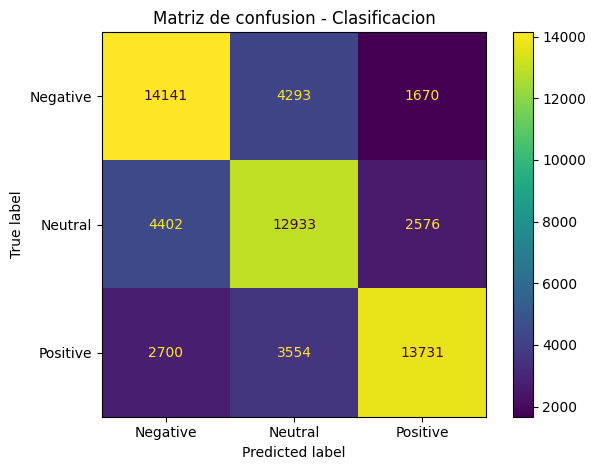

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title("Matriz de confusion - Clasificacion")
plt.tight_layout()
plt.show()

## 3. Selección del mejor modelo (regresión)

Se comparan modelos lineales vistos en clase sobre TF-IDF:

- LinearRegression (referencia)
- Ridge, Lasso, ElasticNet (regularizados)
- SGDRegressor (descenso estocástico)

Métricas:
- MAE (principal, interpretable)
- RMSE
- R²

Se elige el mejor modelo por desempeño promedio en validación cruzada.

In [22]:
Xr = df_work["CommentText"].astype(str)
yr = df_work["y_cont"].astype(float)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    Xr, yr, test_size=0.30, random_state=777
)

X_train_r.shape, X_test_r.shape

((140000,), (60000,))

In [23]:
def evaluate_regressor(pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)

    return {"mae": mae, "rmse": rmse, "r2": r2}

In [24]:
vectorizer_r = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)

models_reg = {
    "LinReg": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1e-4, max_iter=5000),
    "ElasticNet": ElasticNet(alpha=1e-4, l1_ratio=0.15, max_iter=5000),
    "SGDRegressor": SGDRegressor(penalty="l2", alpha=1e-5, random_state=777),
}

results_reg = []
fitted_reg = {}

for name, model in models_reg.items():
    pipe = Pipeline([("tfidf", vectorizer_r), ("model", model)])
    metrics = evaluate_regressor(pipe, X_train_r, y_train_r, X_test_r, y_test_r)
    metrics["model"] = name
    results_reg.append(metrics)
    fitted_reg[name] = pipe

pd.DataFrame(results_reg).sort_values("mae")


,mae,rmse,r2,model
3,1.167452,1.658475,0.105068,ElasticNet
1,1.173876,1.691608,0.068954,Ridge
2,1.185233,1.677203,0.084743,Lasso
4,1.188512,1.676747,0.085241,SGDRegressor
0,11.979354,17.461872,-98.209521,LinReg


In [25]:
pipe_ridge = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ("model", Ridge())
])

grid = {"model__alpha": np.logspace(-2, 3, 15)}

search_ridge = GridSearchCV(
    pipe_ridge, grid, scoring="r2", cv=3, n_jobs=-1, verbose=1
)
search_ridge.fit(X_train_r, y_train_r)

best_reg = search_ridge.best_estimator_
search_ridge.best_params_, search_ridge.best_score_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


({'model__alpha': np.float64(7.196856730011521)},
 np.float64(0.1069938609263587))

In [26]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

pred_r = best_reg.predict(X_test_r)
regression_metrics(y_test_r, pred_r)

(1.1497823066418054, np.float64(1.646674404601847), 0.11775903712725888)

## 4) Interpretación en función del negocio (con coeficientes)

In [27]:
tfidf = best_cls.named_steps["tfidf"]
clf = best_cls.named_steps["model"]

feat = np.array(tfidf.get_feature_names_out())
classes = clf.classes_
coefs = clf.coef_

top_n = 15
for i, c in enumerate(classes):
    top_pos = np.argsort(coefs[i])[-top_n:][::-1]
    print(f"\nClase {c} - términos que empujan hacia {c}:")
    print(feat[top_pos])


Clase Negative - términos que empujan hacia Negative:
['error' 'terrible' 'not' 'stupid' 'fake' 'garbage' 'disgusting' 'worst'
 'seriously' 'dumb' 'awful' 'sad' 'isn' 'trash' 'hate']

Clase Neutral - términos que empujan hacia Neutral:
['is it' 'is that' 'is this' 'can you' 'is there' 'or' 'comment' 'name'
 'could you' 'what is' 'wondering' 'where' '00' 'which' 'thought']

Clase Positive - términos que empujan hacia Positive:
['love' 'great' 'amazing' 'best' 'awesome' 'thank' 'good' 'finally'
 'beautiful' 'loved' 'brilliant' 'respect' 'perfect' 'thank you' 'glad']


In [28]:
tfidf_r = best_reg.named_steps["tfidf"]
reg = best_reg.named_steps["model"]

feat_r = np.array(tfidf_r.get_feature_names_out())
coef_r = reg.coef_

top_n = 20
top_pos = np.argsort(coef_r)[-top_n:][::-1]
top_neg = np.argsort(coef_r)[:top_n]

print("Aumentan engagement (log1p likes):")
print(feat_r[top_pos])

print("\nDisminuyen engagement (log1p likes):")
print(feat_r[top_neg])

Aumentan engagement (log1p likes):
['ben' 'debate' 'edit' 'canadian' 'kyle' 'love how' 'special'
 'congresswoman' 'ukraine' 'her' 'this man' 'proud' 'walz' 'conversation'
 '순간' 'level' 'imagine' 'felt' 'standing' 'crowder']

Disminuyen engagement (log1p likes):
['individuals' 'however' 'significant' 'which' 'likely' 'idiot'
 'can someone' 'encountered' 'for me' 'why' 'garbage' 'terrible'
 'incredibly' 'you people' 'considered' 'guys are' 'china' 'idiots'
 'vehicle' 'appears']
